### <span style="color:rgb(4,139,154)">Optimization for Machine Learning</span>
### <span style="color:rgb(4,139,154)">Master 2 IASD & MASH, 2022-2023</span>

# <span style="color:rgb(4,139,154)">Lab - Proximal gradient and regularization</span>


Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/PGL/LectureNotesOML-PGL.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/PGL/SourcesLabPGL.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@lamsade.dauphine.fr**.

# <span style="color:rgb(4,139,154)">Introduction</span>

This lab session presents several optimization problems with regularization. Our goal is to highlight the impact of regularization over the output of the optimization method.

In [1]:
# Preamble: useful toolboxes, librairies, functions, etc.
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

# SciPy - Efficient mathematical calculation
from scipy.linalg.special_matrices import toeplitz # A special kind of matrices
from scipy.linalg import svdvals # Singular values
from scipy.linalg import norm # Euclidean norm
from scipy.optimize import check_grad # Check accuracy between objective and gradient values
from scipy.optimize import fmin_l_bfgs_b # Efficient optimizer

# <span style="color:rgb(4,139,154)">Part 1 - Data generation</span>

## <span style="color:rgb(4,139,154)">1.1 Dataset</span>

We consider a dataset $\{(\mathbf{a}_i,y_i)\}_{i=1,\dots,n}$, where $\mathbf{a}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$, available in the form of:

- a feature matrix $\mathbf{A} \in \mathbb{R}^{n \times d}$;
- and a vector of labels $\mathbf{y} \in \mathbb{R}^n$. 

The dataset will be produced according to the procedure below, that aims at generating 
data by controlling the noise and correlation levels. 

In [2]:
# Data generation.
# This code is inspired by a generator proposed by A. Gramfort.

def simu_linmodel(x, n, std=1., corr=0.5):
    """
    Simulation values obtained by a linear model with additive noise
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = A.dot(x) + noise
    return A, y

The data is thus produced from a linear model corrupted with noise: $\mathbf{y} = \mathbf{A} \mathbf{x}^* + \mathbf{\epsilon}$, where $\mathbf{\epsilon}$ follows a Gaussian distribution. Our goal will thus be to learn a linear model from the data.

## <span style="color:rgb(4,139,154)">1.2 Linear regression</span>

In *linear regression*, we seek a linear model that explains the data based on minimizing a least-squares objective:
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) 
    := \frac{1}{2 n} \|\mathbf{A} \mathbf{x} - \mathbf{y}\|^2.
$$ 
The objective function $f$ is $\mathcal{C}^1$, and 
$$
    \nabla f(\mathbf{x}) =\frac{1}{n}\mathbf{A}^T (\mathbf{A} \mathbf{x} - \mathbf{y}).
$$
Moreover, $\nabla f$ is $L$-Lipschitz continuous with $L=\frac{\|\mathbf{A}^T \mathbf{A}\|}{n}$.

## <span style="color:rgb(4,139,154)">1.3 Logistic regression</span>

In *logistic regression*, we still consider a linear model, but we use a loss function better suited for classification:
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) 
    := \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x}), \qquad 
    f_i(\mathbf{x})=\log(1+\exp(-y_i \mathbf{a}_i^T \mathbf{x})),
$$
where every $y_i$ is a binary label in $\{-1,1\}$.

As in the case of linear regression, it is possible to show that $f_i \in \mathcal{C}^1(\mathbb{R}^d)$ and 
$f \in \mathcal{C}^{1,1}_L(\mathbb{R}^d)$. Here, we have,
$$
    \nabla f_i(\mathbf{x}) = - \frac{y_i}{1 + \exp(y_i \mathbf{a}_i^T \mathbf{x})} \mathbf{a}_i
$$
and 
$$
    L=\frac{\|\mathbf{A}^T \mathbf{A}\|}{4n}.
$$

## <span style="color:rgb(4,139,154)">1.4 Python class for (unregularized) regression problems</span>

*Implementation: Using the formulae developed above, add the code to compute $f(\mathbf{w})$, $f_i(\mathbf{w})$, $\nabla f_i(\mathbf{w})$ and $\nabla f(\mathbf{w})$ within the Python class encoding the two regression problems above.*

*Useful functions:* For any matrix/2-way Numpy array A,

- ``A.dot(v)`` is the matrix-vector product $A v$ (if X is a vector, this returns the scalar product);
- ``A.T`` is the transpose matrix $X^T$.

- np.log : logarithm applied componentwise on Numpy arrays.
- np.mean : average of the components of a NumPy array

In [3]:
# Python class for regression problems
class RegressionPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            A: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
    '''
   
    # Instantiate the class
    def __init__(self, A, y,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) 
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) 
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n 

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n 
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) 
        return L
    
    # ''Strong'' convexity constant (could be zero)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

We now generate our two problem instances.

In [4]:
# Generate the problem instances - we use moderate sizes but those will serve our purpose

#d = 50
d = 16
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5) # Small value for the regularization parameter

# Fix random seed for reproducibility
np.random.seed(0)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

Alin, ylin = simu_linmodel(x_model_truth, n, std=1., corr=0.1)
Alog, ylog = simu_linmodel(x_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog) # Taking the logarithm for binary classification

pblinreg = RegressionPb(Alin, ylin,loss='l2')
pblogreg = RegressionPb(Alog, ylog,loss='logit')

In [5]:
# Use L-BFGS-B to determine a solution for both problems

x_init = np.zeros(d)
# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))
# Compute the optimal solution for logistic regression
x_min_log, f_min_log, _ = fmin_l_bfgs_b(pblogreg.fun, x_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)

print(f_min_log)
print(norm(pblogreg.grad(x_min_log)))

0.4725999960108297
9.55175288672927e-10
0.4605518092721485
1.3638801295372946e-09


# <span style="color:rgb(4,139,154)">Part 2 - Regularization with an $\ell_2$ norm</span>

## <span style="color:rgb(4,139,154)">2.1 Linear regression with $\ell_2$ regularization</span>

In this section, we consider a first form of regularization that involves a smooth function, which we apply to a linear regression problem. The problem at hand is
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f_{\ell_2}(\mathbf{x}) = \frac{1}{2n} \|\mathbf{A} \mathbf{x} - \mathbf{y}\|^2 + \frac{\lambda}{2} \|x\|^2,
$$
commonly called *ridge regression* problem.

Note that the function $f_{\ell_2}$ is continuously differentiable, and that its gradient is given by:
$$
\nabla f_{\ell_2}(\mathbf{x}) = \tfrac{\mathbf{A}^T \mathbf{A}+ \lambda n \mathbf{I}}{n} \mathbf{x} -\mathbf{A}^T \mathbf{y}. 
$$
It can be shown that $\nabla f_{\ell_2}$ is $(L+\lambda)$-Lipschitz continuous.

***In the context of linear regression $\ell_2$ regularization can be interpreted in several ways:***

1) In terms of linear algebra: Regularizing the optimality conditions linear system $\mathbf{A}^T \mathbf{A} \mathbf{x} = \mathbf{A}^T \mathbf{y}$ into another system with a unique solution for $\lambda>0$.

2) In terms of optimization: The regularized optimization problem is strongly convex (and continuous), hence it possesses a single global minimum.

3) As $\lambda \rightarrow \infty$, the regularization term reduces the dependency of the solution to the data, and, consequently, its variance with respect to the data.

4) Implicitly, this regularization enforces a constraint on the $\ell_2$ norm of the solution.

## <span style="color:rgb(4,139,154)">2.2 Gradient descent with $\ell_2$ regularization</span>

The code below is a basic modification of the classical gradient descent method (see Lab 2) that accounts for 
a regularizing term.

In [6]:
# Implementation of gradient descent
def gd_l2(x0,problem,lbda,xtarget,stepchoice=0,step0=1, n_iter=1000, verbose=False): 
    """
        A code for gradient descent for problems with l2 regularization.
        
        Inputs:
            x0: Initial vector
            problem: Problem structure
                problem.fun(x) evaluates the objective function at a given vector w
                problem.grad(x) evaluates the gradient of the objective function at a vector w
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
            lbda: Regularization parameter
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize (see above)
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/(k+1)
                2: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            x_output: Final iterate of the method
            objvals: History of function values (output as a NumPy array of length at most n_iter)
            normits: History of distances between iterates and optimum (NumPy array of length at most n_iter)
            normgrads: History of gradient norms (output as NumPy array of length at most n_iter)
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # gradient norms
    normgrads = []
    
    # Lipschitz constant for the regularized problem
    L = problem.lipgrad() + lbda
    
    # Initial value of current iterate   
    x = x0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = problem.fun(x)  + lbda* norm(x) ** 2 / 2.
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    # Current gradient norm
    g = problem.grad(x) + lbda * x
    ng = norm(g)
    normgrads.append(ng)

    # Plot the initial values if required
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist","ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8),("%.2e" % ng).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):

        # Select the stepsize and perform the update
        if stepchoice==0:
            x[:] = x - (1/L) * g
        elif stepchoice==1:
            x[:] = x - (step0/(k+1))*g
        else:
            x[:] = x - (step0/(sqrt(k+1)))*g
        
        # Compute and plot the new objective value and distance to the minimum
        obj = problem.fun(x) + lbda * norm(x)**2 /2.
        objvals.append(obj)
        nmin = norm(x-xtarget)
        normits.append(nmin)
        # Compute the gradient
        g = problem.grad(x) + lbda * x
        ng = norm(g)
        normgrads.append(ng)
        
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8),("%.2e" % ng).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    x_output = x.copy()
    return x_output, np.array(objvals), np.array(normits), np.array(normgrads)

The block below plots the behavior of gradient descent for several regularization values of the problem.

Squared solution norm with lbda=0: 5.52495268835425
Squared solution norm with lbda=0.1: 4.39860482383225
Squared solution norm with lbda=1: 1.153782749077568
Squared solution norm with lbda=10: 0.03430870631522001
Squared solution norm with lbda=100: 0.00040009948805066694


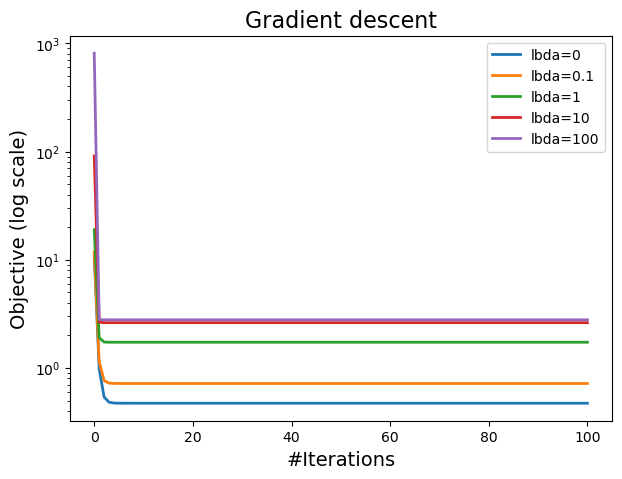

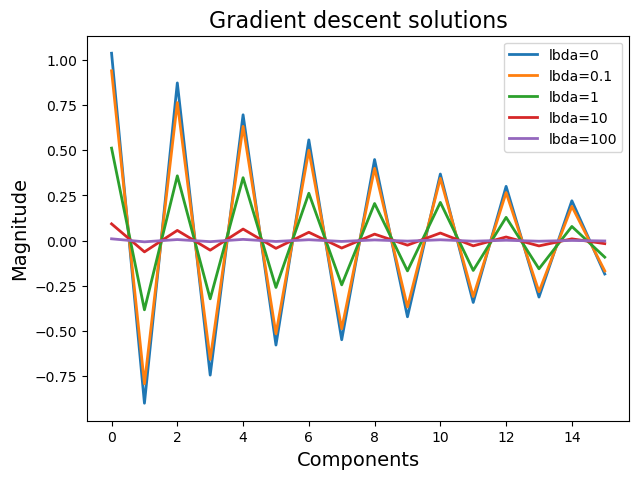

In [7]:
# Testing l2 regularization
lvals = [0,0.1,1,10,100]
nlbda = len(lvals)
lbda = 100
x0 = np.ones(d)
Xsol = np.zeros((d,nlbda))

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    lbda =lvals[i]
    Xsol[:,i], obj_gd, _,_ = gd_l2(x0,pblinreg,lbda,x_min_lin,stepchoice=0,step0=1, n_iter=100)
    print("Squared solution norm with lbda="+str(lbda)+": "+str(norm(Xsol[:,i])**2))
    plt.semilogy(obj_gd, label="lbda="+str(lbda), lw=2)
plt.title("Gradient descent", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    plt.plot(Xsol[:,i],label="lbda="+str(lvals[i]), lw=2)
plt.title("Gradient descent solutions", fontsize=16)
plt.xlabel("Components", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1)

The $\ell_2$ norm smoothes out the solution and leads to solutions with increasingly smaller norms. We can observe 
that the solution components shrink in a rather uniform (aka, smooth) fashion.

# <span style="color:rgb(4,139,154)">Part 3 - Regularization with an $\ell_1$ norm</span>

## <span style="color:rgb(4,139,154)">3.1 Logistic regression with $\ell_1$ regularization</span>

We now consider $\ell_1$ regularization applied to the logistic regression problem:
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f_{\ell_1}(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x}) + \lambda \|\mathbf{x}\|_1,
$$
where $f_i(\mathbf{x})=\log(1+\exp(-y_i \mathbf{a}_i^T \mathbf{x}))$, $\lambda \ge 0$, and $\|\mathbf{x}\|_1 = \sum_{i=1}^n \left|\left[\mathbf{x}\right]_i\right|$.

The objective function $f_{\ell_1}$ is not differentiable because of the $\ell_1$ penalty term, therefore we cannot apply gradient descent directly. An alternative would be to rely on subgradients.

## <span style="color:rgb(4,139,154)">3.2 ISTA for $\ell_1$ regularized smooth problems</span>

We recall the basics of the *Iterative Soft-Thresholding Algorithm* (ISTA) below.

Given an iterate $\mathbf{x}_k$ and a positive stepsize $\alpha_k$, the gradient step with respect to the smooth 
part of the objective is given by:
$$
    \mathbf{g}_k = \mathbf{x}_k - \alpha_k \nabla f(\mathbf{x}_k),
$$
where we recall that $f$ denotes the smooth part of 
$f_{\ell_1}(\mathbf{x}) = f(\mathbf{x}) + \lambda \|\mathbf{x}\|_1$.

The next iterate $\mathbf{x}_{k+1}$ is defined componentwise as follows:
$$
    \forall i=1,\dots,d, \quad [\mathbf{w}_{k+1}]_i \; = \; 
    \left\{
        \begin{array}{ll}
            [\mathbf{g}_k]_i + \lambda \alpha_k &\mathrm{if} [\mathbf{g}_k]_i < -\lambda \alpha_k \\
            [\mathbf{g}_k]_i - \lambda \alpha_k &\mathrm{if} [\mathbf{g}_k]_i > \lambda \alpha_k \\
            0 &\mathrm{otherwise.}
        \end{array}
    \right.
$$

The proximal form of the ISTA iteration is
$$
    \mathbf{x}_{k+1} \in \mathrm{argmin}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}_k) + \nabla f(\mathbf{x}_k)^\top (\mathbf{x}-\mathbf{x}_k) + \frac{1}{2\alpha_k}\|\mathbf{x}-\mathbf{x}_k\|^2 + \lambda \|\mathbf{x}\|_1.
$$
A more general proximal gradient iteration would replace the $\ell_1$ norm by the chosen regularizer, regardless of 
the smoothness properties of this method. In the general case, and unlike in the $\ell_1$ case, the solution may not be unique.

The code below implements ISTA with various stepsize choices.

In [8]:
# Implementation of ISTA
def ista(x0,problem,lbda,stepchoice=0,step0=1, n_iter=1000,verbose=False): 
    """
        A code for ISTA with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun(x) evaluates the objective function (which is assumed to be a finite sum of functions) at a given vector w
                problem.n returns the number of components in the finite sum
                problem.grad(x) evaluates the gradient of the smooth part of the objective function at a vector w
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
            lbda: Regularization parameter
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/(k+1)
                2: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations
            
        Outputs:
            x_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length n_iter at most)
    """   
    
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of current iterate   
    x = x0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);

    step=step0 # Initialize constant stepsize
    threshold=0 # Initialize threshold for proximal step
    
    # Display initial quantities
    if verbose:
        print("ISTA:")
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    
    ##########################
    # Main loop
    while (k < n_iter):
        # Compute the gradient of the smooth part
        g = problem.grad(x)
        # Select the stepsize
        if stepchoice==0:
            step = 1/L
        elif (stepchoice==1):
            step = step0/(k+1)
        else:
            step = step0/(sqrt(k+1))
        
        # Compute the proximal gradient step
        for i in range(problem.d):
            vali = x[i]-step*g[i]
            threshold = step*lbda
            if vali < -threshold:
                x[i] = vali+threshold
            elif vali > threshold:
                x[i] = vali-threshold
            else:
                x[i] = 0
            
        # Update objective value and iteration index
        obj = problem.fun(x)
        objvals.append(obj);
        k += 1
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))       
        
    # Output 
    x_output = x.copy()
          
    return x_output, np.array(objvals)

We then compare the behavior of ISTA for several values of the regularization parameter, namely:
$$
    \left\{0,\frac{1}{n},\frac{1}{n^{3/4}},\frac{1}{n^{2/3}}, \frac{1}{n^{1/2}}, \frac{1}{n^{1/3}}\right\}.
$$

Nonzero coefficients with lbda=0: 16
Nonzero coefficients with lbda=0.001: 16
Nonzero coefficients with lbda=0.005623413251903491: 16
Nonzero coefficients with lbda=0.010000000000000004: 14
Nonzero coefficients with lbda=0.03162277660168379: 6
Nonzero coefficients with lbda=0.10000000000000002: 1


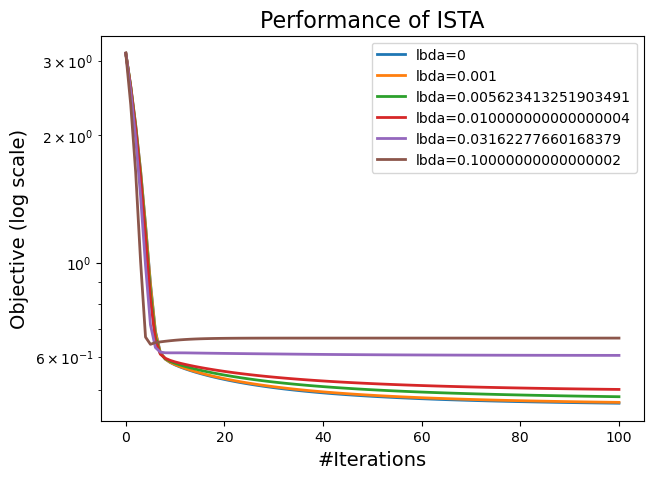

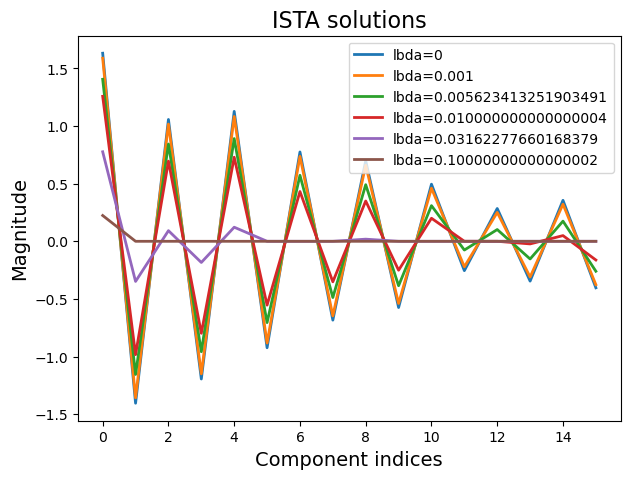

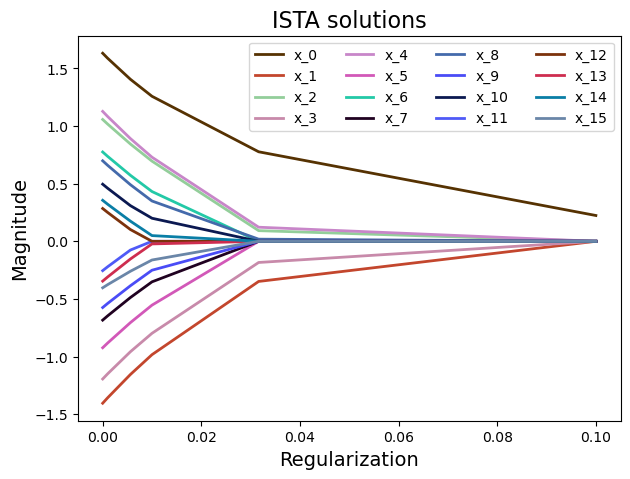

In [14]:
# Testing l1 regularization
lvals = [0,1./n,1./(n**(3/4)),1./(n**(2/3)),1./(n**(1/2)),1./(n**(1/3))]
nlbda = len(lvals)
lbda = 100
x0 = np.ones(d)
Xsol = np.zeros((d,nlbda))

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    lbda =lvals[i]
    Xsol[:,i], obj_is = ista(x0,pblogreg,lbda,stepchoice=0,step0=1, n_iter=100)
    print("Nonzero coefficients with lbda="+str(lbda)+": "+str(np.count_nonzero(Xsol[:,i])))
    plt.semilogy(obj_is, label="lbda="+str(lbda), lw=2)
plt.title("Performance of ISTA", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    plt.plot(Xsol[:,i],label="lbda="+str(lvals[i]), lw=2)
plt.title("ISTA solutions", fontsize=16)
plt.xlabel("Component indices", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(7, 5))
for i in range(d):
    plt.plot(lvals,Xsol[i,:],label="x_"+str(i),c=np.random.rand(3,), lw=2)
plt.title("ISTA solutions", fontsize=16)
plt.xlabel("Regularization", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(ncol=4,loc=1)

These results confirm that the $\ell_1$ regularization leads to sparser solutions. Indeed, as we increase the regularization parameter, the number of zero components increase (and only the largest components remain).

In [10]:
# Version 2.5 - C. W. Royer, November 2022.